In [1]:
!nvidia-smi

Wed Sep 25 16:57:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
%pip install cupy-cuda12x

In [12]:
import numpy as np
import cupy as cp
import time

def matrix_multiply_cpu(A, B):
    '''
    Функция для выполнения умножения матриц на CPU
    :param: matrixA - первая матрица
    :param: matrixB - вторая матрица
    :return: [
      answer - результат умножения,
      время выполнения операции
    ]
    '''
    # Проверка корректности перемножения
    if A.shape[1] != B.shape[0]:
        raise ValueError("Неправильные размеры матриц для перемножения")

    answer = np.zeros((A.shape[0], B.shape[1]))

    start_time = time.time()
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                answer[i, j] += A[i, k] * B[k, j]
    end_time = time.time()

    return answer, end_time - start_time

def matrix_multiply_gpu(A, B):
    '''
    Функция для выполнения умножения матриц на GPU
    :param: A - первая матрица
    :param: B - вторая матрица
    :return: [
      answer - результат умножения,
      время выполнения операции
    ]
    '''
    # Проверка корректности перемножения
    if A.shape[1] != B.shape[0]:
        raise ValueError("Неправильные размеры матриц для перемножения")

    # Перенос матриц на GPU
    A_in_gpu = cp.asarray(matrix_a)
    B_in_gpu = cp.asarray(matrix_b)

    start_time = time.time()
    answer_in_gpu = cp.dot(A_in_gpu, B_in_gpu)

    # Возвращаем результат c GPU на CPU
    answer = cp.asnumpy(answer_in_gpu)
    end_time = time.time()

    return answer, end_time - start_time

if __name__ == "__main__":
    size = (100, 100)
    low = 1
    high = 10
    matrix_a = np.random.randint(low, high, size)
    matrix_b = np.random.randint(low, high, size)


    answer_function = np.dot(matrix_a, matrix_b)

    answer_gpu, time_gpu = matrix_multiply_gpu(matrix_a, matrix_b)
    print(f"Результат на GPU:\n{answer_gpu}")
    print(f"Соответствие результата с np.dot(): {np.unique(answer_gpu == answer_function)}")
    print(f"Время на GPU: {time_gpu} секунд")

    answer_cpu, time_cpu = matrix_multiply_cpu(matrix_a, matrix_b)

    print(f"Результат на CPU:\n{answer_cpu}")
    print(f"Соответствие результата с np.dot(): {np.unique(answer_cpu == answer_function)}")
    print(f"Время на CPU: {time_cpu} секунд")



Результат на GPU:
[[2610 2706 2320 ... 2644 2616 2564]
 [2433 2336 2122 ... 2308 2395 2407]
 [2143 2226 1837 ... 2337 2194 2176]
 ...
 [2279 2393 2167 ... 2502 2441 2386]
 [2695 2736 2275 ... 2628 2595 2644]
 [2467 2565 2313 ... 2596 2434 2439]]
Соответствие результата с np.dot(): [ True]
Время на GPU: 0.0004215240478515625 секунд
Результат на CPU:
[[2610. 2706. 2320. ... 2644. 2616. 2564.]
 [2433. 2336. 2122. ... 2308. 2395. 2407.]
 [2143. 2226. 1837. ... 2337. 2194. 2176.]
 ...
 [2279. 2393. 2167. ... 2502. 2441. 2386.]
 [2695. 2736. 2275. ... 2628. 2595. 2644.]
 [2467. 2565. 2313. ... 2596. 2434. 2439.]]
Соответствие результата с np.dot(): [ True]
Время на CPU: 0.6759786605834961 секунд


Поскольку время на выполнение операций умножения для двух последних размеров не представляется измеримым, попробую его предположить используя тренд данных, которые были получены ранее.

Была проанализирована зависимость времени от размера и интерполирована на нужные размеры.

Ниже реализована простая модель зависимости: время пропорционально N**3.

Понимаю, что результаты очень далеки будут от реальных, но в этом есть небольшая логика, и это лучше, чем ничего :)

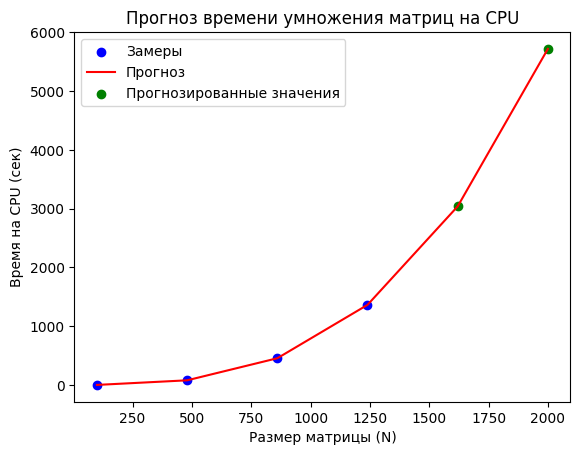

Примерное время для 1620: 3038.7580413804426
Примерное время для 2000: 5717.959362150158


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Данные
sizes = np.array([100, 480, 860, 1240])  # Размер матрицы
times_cpu = np.array([0.655572, 78.525480, 452.908478, 1363.350222])  # Время на CPU

# Модель зависимости: время пропорционально N**3
def time_model(N, a):
    return a * N**3

# Подгонка модели под данные
popt, _ = curve_fit(time_model, sizes, times_cpu)

# Прогноз времени для размеров 1620 и 2000
sizes_predict = np.array([1620, 2000])
times_predict = time_model(sizes_predict, *popt)

# Визуализация
plt.scatter(sizes, times_cpu, label="Замеры", color='blue')
plt.plot(np.concatenate([sizes, sizes_predict]),
         time_model(np.concatenate([sizes, sizes_predict]), *popt), label="Прогноз", color='red')
plt.scatter(sizes_predict, times_predict, label="Прогнозированные значения", color='green')
plt.xlabel("Размер матрицы (N)")
plt.ylabel("Время на CPU (сек)")
plt.legend()
plt.title("Прогноз времени умножения матриц на CPU")
plt.show()

print(f"Примерное время для {sizes_predict[0]}: {times_predict[0]}")
print(f"Примерное время для {sizes_predict[1]}: {times_predict[1]}")